Auteurs du rapport  : Kastriot Kozhani, Blerdon D√©bieux, Kevin Zulliger 
# RealEstateScout - Pr√©dictions des prix de ventes de maisons

## Introduction - phase z√©ro 
Avez-vous d√©j√† mis en vente ou en location un bien immobilier sans savoir quel prix lui attribuer ? 

Notre √©quipe de data scientists est charg√©e de d√©velopper une marketplace mettant en relation les acheteurs et les vendeurs d'immobilier. En offrant des pr√©dictions de prix pr√©cises, nous inciterons les vendeurs √† fournir un maximum de d√©tails sur leurs biens. Les vendeurs renseignant le plus de param√®tres seront r√©compens√©s par une r√©duction sur le co√ªt de leur annonce. Cela nous garantira une meilleure qualit√© des donn√©es, am√©liorant ainsi la pr√©cision de notre syst√®me de pr√©diction. 

Le type de t√¢che que nous avons souhait√© r√©aliser est une r√©gression pour pr√©dire le prix de vente d'une propri√©t√©, le tout principalement en faveur des agences immobili√®res.
La raison est simple: la pr√©diction des prix de l'immobilier repr√©sente un enjeu crucial pour les agences immobili√®res et les vendeurs de propriet√©s. Ces derni√®res pourront utiliser nos pr√©dictions pour fixer des prix de vente comp√©titifs qui refl√®tent la valeur r√©elle du march√© immobilier. De ce fait, les agences immobili√®res renforceront leur position sur le march√© tout en am√©liorant la satisfaction de ses clients.
Pour arriver √† notre but, nous avons entrepris de d√©velopper un mod√®le de Machine Learning robuste, capable de pr√©dire l'estimation du prix de vente d'une maison sur la base de diff√©rents crit√®res et donn√©es.

Ce projet s'inscrit dans un contexte o√π la d√©termination d'un prix de vente juste et comp√©titif est essentiel pour optimiser la visibilit√© des annonces, acc√©l√©rer les transactions et maximiser les revenus des vendeurs. Pour atteindre ces objectifs, nous avons adopt√© une m√©thodologie bas√©e sur le processus CRISP-ML (Cross-Industry Standard Process for Data Mining), qui nous guide de la compr√©hension initiale des donn√©es jusqu'au d√©ploiement final du mod√®le.

## Phase d'id√©ation - Exploration du jeu de donn√©es 

### Crit√®res de succ√®s 
- Performance du mod√®le 
- marketplace adapt√© au besoin
- La m√©trique utilis√©e pour d√©finir si notre mod√®le sera performant sera le RMSLE. Cette derni√®re est math√©matiquement d√©finie de la mani√®re suivante: 

$$
\text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(p_i + 1) - \log(a_i + 1))^2}
$$

  -- Un score bas indiquera que notre mod√®le sera performant. L'objectif sera d'obtenir un score RMSLE en dessous de 0.12, ce qui serait un objectif challenging pour ce projet. Dans la pratique, cela se traduira par une pr√©dictions des prix de maisons proches de la r√©alit√©. 

- Un autre crit√®re de succ√®s sera que notre marketplace r√©ponde aux besoins des vendeurs ainsi que des acheteurs. Les deux parties devront se familiariser assez rapidement avec notre plateforme.
Nous √©valuerons ce crit√®re √† travers des tests d'utilisabilit√© et des retours d'exp√©rience des utilisateurs.

## Importation des donn√©es et constitution de la pipeline

Cette √©tape importe les biblioth√®ques n√©cessaires pour la manipulation des donn√©es, la visualisation, et les techniques de mod√©lisation. Elle est cruciale pour configurer notre environnement de travail et assurer que nous avons tous les outils n√©cessaires pour le traitement des donn√©es ainsi que pour la mod√©lisation.

In [50]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import TargetEncoder  # Import du TargetEncoder de sklearn
import xgboost as xgb
import optuna
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

Nous commen√ßons par charger les donn√©es d'entra√Ænement et de test √† partir des fichiers CSV √† disposition sur Kaggle. L'affichage des premi√®res lignes nous a permis de consulter la structure des donn√©es initiale ainsi que de v√©rifier l'importation.

In [51]:
train_data = pd.read_csv('Data/train.csv',index_col="Id" )
test_data = pd.read_csv('Data/test.csv',index_col="Id" )

Nous avons  trouv√© que les ventes partielles constituaient un danger dans la pr√©diction car ces ventes d√©finies comme telles n'ont en fait jamais √©t√© conclues. Nous les avons donc supprimer de notre dataset afin d'√©viter des biais. 

In [52]:
train_data = train_data[train_data['SaleCondition'] != 'Partial']

Nous avons ensuite d√©finit les colonnes selon leur type (num√©riques, cat√©gorielles, ordinales, dichotomiques). Cette √©tape est essentielle afin d'appliquer des techniques de pr√©traitement qui sont sp√©cifiques √† chaque type de donn√©es. Voici les diff√©rents types de donn√©es √† disposition:

- Features num√©riques : Variables quantitatives mesur√©es sur une √©chelle num√©rique.
- Features cat√©gorielles : Variables qualitatives qui peuvent prendre plusieurs cat√©gories.
- Features ordinales : Variables qualitatives ordonn√©es qui ont une relation d'ordre.
- Features dichotomiques : Variables qui prennent deux valeurs possibles (oui/non).

In [53]:
numeric_features = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
                    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                    'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                    'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 
                    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
                    'MiscVal', 'MoSold', 'YrSold']

categorical_features = ['MSSubClass', 'MSZoning', 'Alley', 'Neighborhood', 'Condition1', 'Condition2', 
                        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                        'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 
                        'SaleType', 'SaleCondition']

ordinal_features = ['LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'OverallQual', 
                    'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 
                    'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

dichotomous_features = ['CentralAir', 'Street']

# Compr√©hension des donn√©es

Comme expliqu√© dans l'exploration du jeu de donn√©es, le dataset utilis√© contient des informations d√©taill√©es sur diff√©rentes propri√©t√©s, incluant des caract√©ristiques comme la superficie, l'ann√©e de construction, la qualit√© des mat√©riaux, etc. Nous avons commenc√© par une analyse exploratoire des donn√©es pour identifier les caract√©ristiques les plus influentes et comprendre leur distribution.

## Analyse exploratoire
- **MSSubClass**: Classe du b√¢timent
- **MSZoning**: Classification de la zone
- **LotArea**: Taille du terrain
- **OverallQual**: Qualit√© g√©n√©rale des mat√©riaux et de la finition
- **YearBuilt**: Ann√©e de construction

Nous avons observ√© que certaines variables comme `OverallQual` et `GrLivArea` avaient une forte corr√©lation avec le prix de vente, , ce qui nous permet de mieux comprendre les facteurs influen√ßant les prix des maisons


# Pr√©paration des donn√©es

Pour garantir la qualit√© des pr√©dictions, il est n√©cessaire d'avoir un jeu de donn√©es bien pr√©par√©. Nous avons ainsi effectu√© les √©tapes suivantes :

1. **Nettoyage des donn√©es** : Gestion des valeurs manquantes et des anomalies.
2. **Transformation des variables** : Encodage des variables cat√©gorielles, normalisation des variables num√©riques.
3. **Feature Engineering** : Cr√©ation de nouvelles variables bas√©es sur les caract√©ristiques existantes, comme l'√¢ge de la maison depuis sa construction.

## Matrice de corr√©lation

Afin de savoir quelles variables sont le plus d√©cisives dans la d√©finition du prix d'une maison, nous avons proc√©d√© √† l'affichage d'une matrice de corr√©lation afin de constater quelles sont les variables de notre data set qui sont le plus corr√©l√©es.

Pour cela, nous avons suivis quelques √©tapes :

1. **Calcul de la matrice de corr√©lation :** Nous avons commen√ß√© par calculer la matrice de corr√©lation pour les variables num√©riques. Cette matrice nous a montr√© les coefficients de corr√©lation entre chaque paire de variables, indiquant √† quel point elles sont lin√©airement li√©es.

2. **Filtrage des corr√©lations significatives :** Nous avons ensuite filtr√©s les corr√©lations pour ne conserver que celles qui sont sup√©rieures √† 0.8 ou inf√©rieures √† -0.8. Cela nous a permis de nous concentrer sur les relations les plus fortes, qui ont le plus d'impact sur le prix de vente des maisons.

3. **Affichage de la matrice de corr√©lation filtr√©e :** Enfin, nous avons affich√© la matrice de corr√©lation filtr√©e √† l'aide d'une heatmap. Les valeurs NaN (non significatives) ont √©t√© masqu√©es pour une plus grande lisibilit√©.

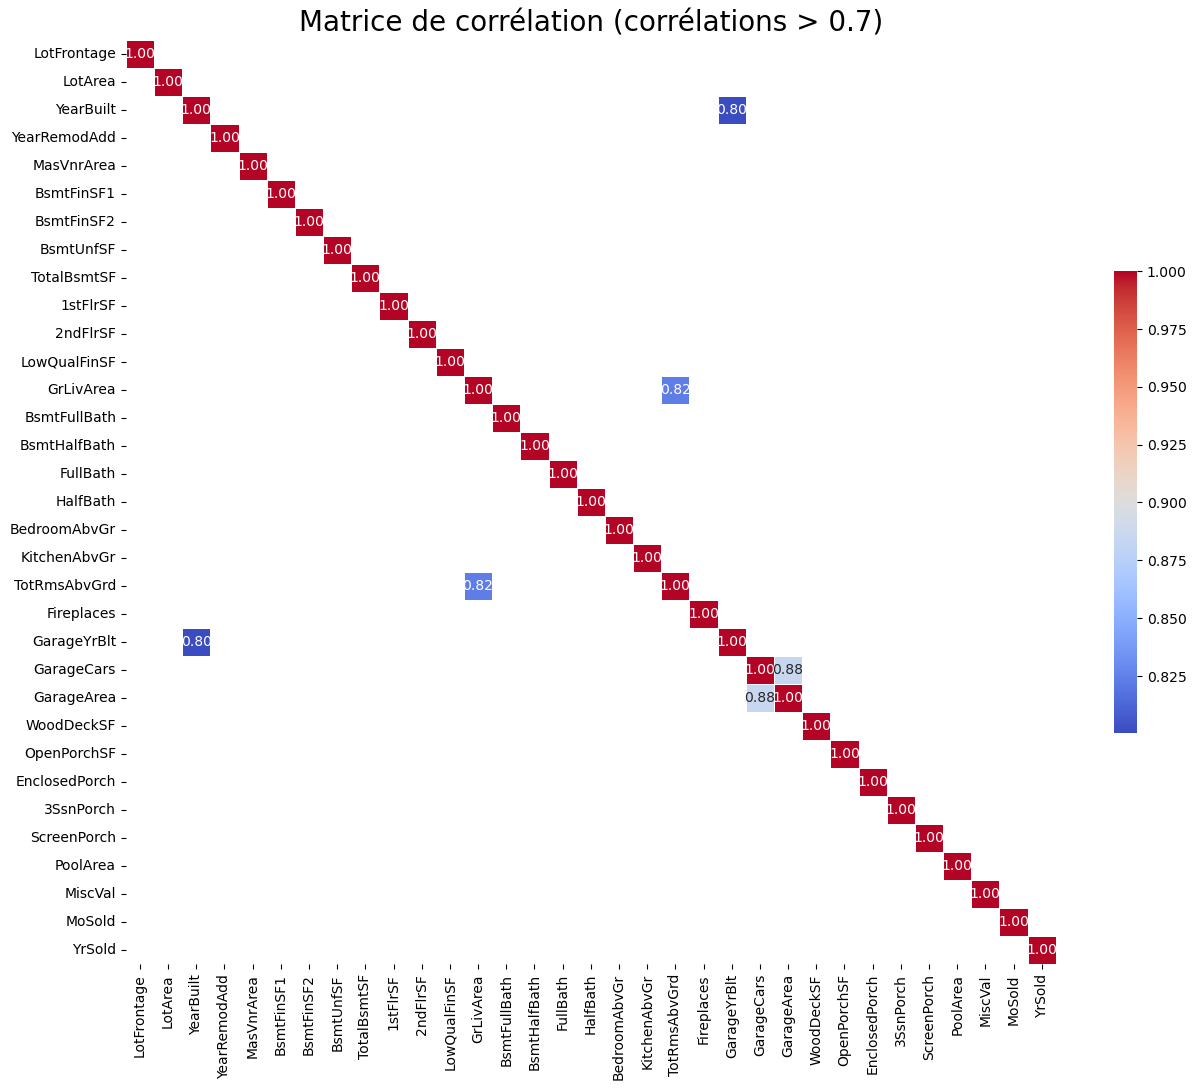

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculer la matrice de corr√©lation
numeric_data = train_data[numeric_features]
correlation_matrix = numeric_data.corr()

# Filtrer les corr√©lations sup√©rieures √† 0.8 ou inf√©rieures √† -0.8
filtered_corr_matrix = correlation_matrix[(correlation_matrix.abs() >= 0.8)]

# Masquer les valeurs NaN pour l'affichage
mask = np.isnan(filtered_corr_matrix)

# Afficher la matrice de corr√©lation filtr√©e
plt.figure(figsize=(15, 12))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, mask=mask, cbar_kws={"shrink": .5})
plt.title('Matrice de corr√©lation (corr√©lations > 0.7)', fontsize=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


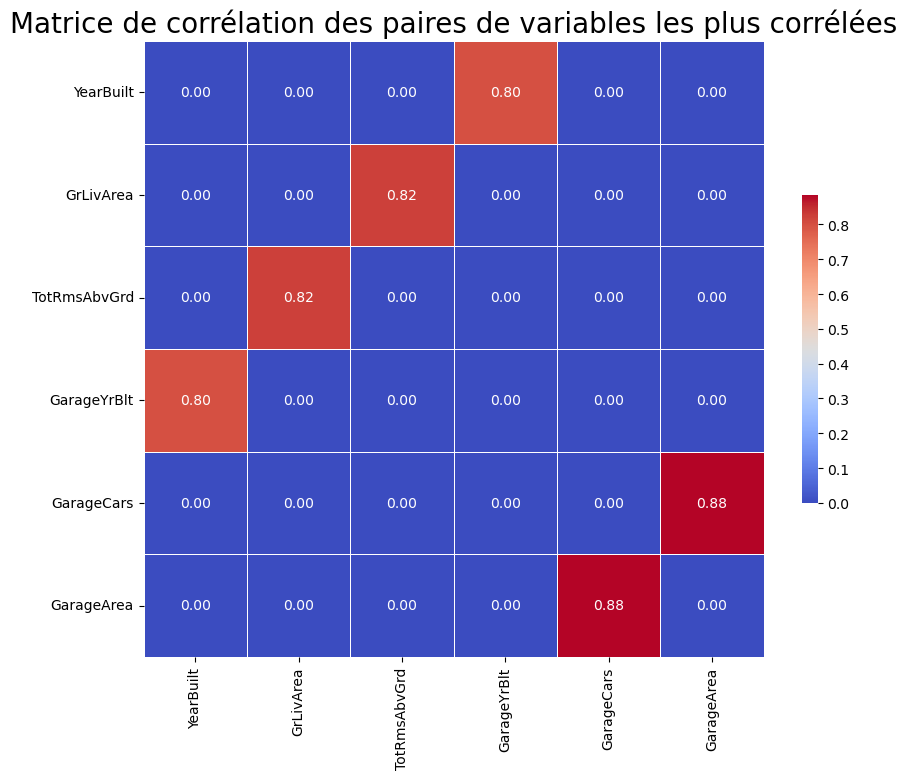

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculer la matrice de corr√©lation
correlation_matrix = numeric_data.corr()

# S√©lectionner les paires de variables les plus corr√©l√©es
high_corr_pairs = [
    ('GarageYrBlt', 'YearBuilt'),
    ('TotRmsAbvGrd', 'GrLivArea'),
    ('GarageArea', 'GarageCars')
]

# Cr√©er une nouvelle DataFrame pour contenir uniquement les paires s√©lectionn√©es
high_corr_matrix = pd.DataFrame(0, index=numeric_data.columns, columns=numeric_data.columns)

for pair in high_corr_pairs:
    high_corr_matrix.loc[pair[0], pair[1]] = correlation_matrix.loc[pair[0], pair[1]]
    high_corr_matrix.loc[pair[1], pair[0]] = correlation_matrix.loc[pair[1], pair[0]]

# Filtrer les lignes et colonnes qui ne contiennent que des z√©ros
high_corr_matrix = high_corr_matrix.loc[(high_corr_matrix != 0).any(axis=1), (high_corr_matrix != 0).any(axis=0)]

# Afficher la matrice de corr√©lation filtr√©e
plt.figure(figsize=(10, 8))
sns.heatmap(high_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Matrice de corr√©lation des paires de variables les plus corr√©l√©es', fontsize=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


#### **Conclusion de la matrice** 

***YearBuilt - GarageYrBlt (0.80)***

YearBuilt : Ann√©e de construction de la maison.
GarageYrBlt : Ann√©e de construction du garage.

Interpr√©tation : Il est logique que l'ann√©e de construction de la maison et du garage soient fortement corr√©l√©es, car les garages sont souvent construits en m√™me temps que les maisons.

***TotRmsAbvGrd - GrLivArea (0.82)***

TotRmsAbvGrd : Nombre total de pi√®ces au-dessus du sol (ne comprend pas les salles de bains).

GrLivArea : Surface habitable au-dessus du sol en pieds carr√©s.

Interpr√©tation : Une plus grande surface habitable est g√©n√©ralement associ√©e √† un plus grand nombre de pi√®ces.

***GarageArea - GarageCars (0.88)***

GarageArea : Surface du garage en pieds carr√©s.
GarageCars : Capacit√© du garage en nombre de voitures.

Interpr√©tation : La surface du garage est directement li√©e √† la capacit√© du garage en termes de nombre de voitures. Plus la surface est grande, plus le garage peut accueillir de voitures.

In [56]:
# Data preprocessing with pipelines
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

dichotomous_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='if_binary'))
])

# Combine features in ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, categorical_features),
        ('num', numeric_pipeline, numeric_features),
        ('ord', ordinal_pipeline, ordinal_features),
        ('dich', dichotomous_pipeline, dichotomous_features)
    ])


# S√©paration de la variable cible et des caract√©ristiques.
# Transformation du prix de vente en utilisant la fonction log1p pour normaliser les valeurs et r√©duire l'impact des valeurs extr√™mes.
y_train = np.log1p(train_data['SalePrice'])
X_train = train_data.drop(['SalePrice'], axis=1)

# Application du ColumnTransformer aux donn√©es d'entra√Ænement et de test.
# Cette √©tape applique toutes les transformations d√©finies pr√©c√©demment aux donn√©es.
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_test_transformed = preprocessor.transform(test_data)

preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['MSSubClass', 'MSZoning', 'Alley',
                                  'Neighborhood', 'Condition1', 'Condition2',
                                  'BldgType', 'HouseStyle', 'RoofStyle',
                                  'RoofMatl', 'Exterior1st', 'Exterior2nd',
                                  'MasVnrType', 'Foundation', 'Heating',
                                  'Elec...
                                  'OverallCond', 'ExterQual', 'ExterCond',
                                  'BsmtQual', 'BsmtCond', 'BsmtExposure',
                                  'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                                  'KitchenQual', 'Functional', 'FireplaceQu',
                                  'GarageFinish', 'GarageQual', 'GarageCond',
                                  'PavedDrive', 'PoolQC', 'Fence']),
                                ('dich',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['CentralAir', 'Street'])])

In [57]:

# Converting back to Pandas DataFrame
X_train_df = pd.DataFrame(X_train_transformed, index=train_data.index)
X_test_df = pd.DataFrame(X_test_transformed, index=test_data.index)

# Afficher les 5 premi√®res lignes du jeu de donn√©es pr√©trait√© pour v√©rifier
print(X_train_df.head())
print(X_test_df.head())

    0    1    2    3    4    5    6    7    8    9    ...  212  213  214  215  \
Id                                                    ...                       
1   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  6.0  4.0  1.0  4.0   
2   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  6.0  4.0  1.0  4.0   
3   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  6.0  4.0  1.0  4.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  6.0  2.0  2.0  4.0   
5   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  6.0  4.0  1.0  4.0   

    216  217  218  219  220  221  
Id                                
1   4.0  2.0  0.0  2.0  1.0  1.0  
2   4.0  2.0  0.0  2.0  1.0  1.0  
3   4.0  2.0  0.0  2.0  1.0  1.0  
4   4.0  2.0  0.0  2.0  1.0  1.0  
5   4.0  2.0  0.0  2.0  1.0  1.0  

[5 rows x 222 columns]
      0    1    2    3    4    5    6    7    8    9    ...  212  213  214  \
Id                                                      ...                  
1461  1

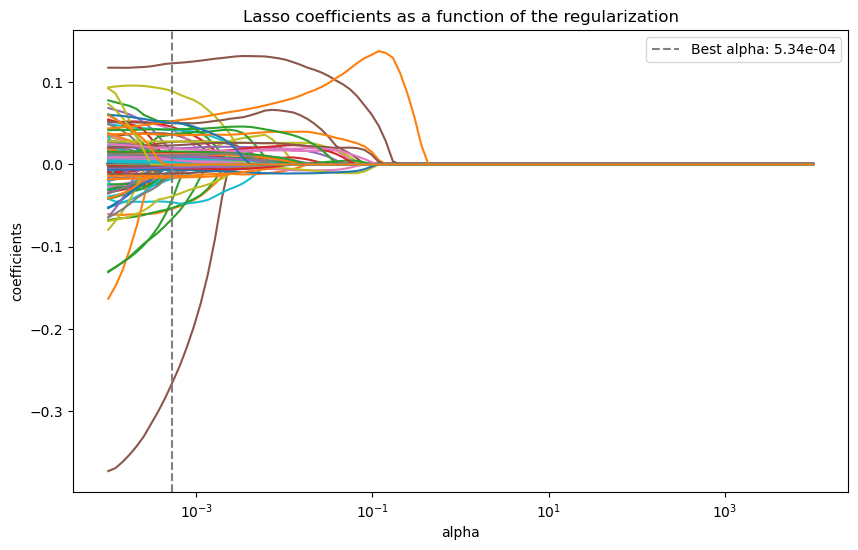

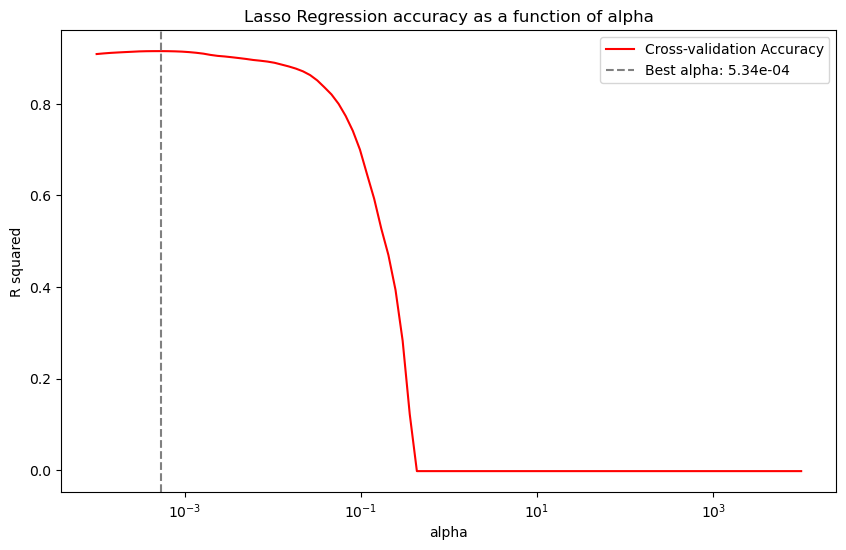

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.exceptions import ConvergenceWarning
import warnings

# Filtrer les avertissements de convergence
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# D√©finir les alphas pour Lasso
lasso_alphas = 10**np.linspace(-4, 4, 100)

# Entra√Ænement de la r√©gression Lasso et collecte des coefficients et scores de validation crois√©e
lasso_regression = Lasso(max_iter=20000)
lasso_coefs = []
lasso_cv = []

for alpha in lasso_alphas:
    lasso_regression.set_params(alpha=alpha)
    lasso_regression.fit(X_train_df, y_train)
    lasso_coefs.append(lasso_regression.coef_)
    scores = cross_val_score(lasso_regression, X_train_df, y_train, cv=5, scoring='r2')
    lasso_cv.append(scores.mean())

# Trouver l'alpha avec la meilleure pr√©cision (score moyen le plus √©lev√©)
best_alpha = lasso_alphas[np.argmax(lasso_cv)]

# Tracer les coefficients en fonction des alphas
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(lasso_alphas, lasso_coefs)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title('Lasso coefficients as a function of the regularization')
plt.axvline(x=best_alpha, color='grey', linestyle='--', label=f'Best alpha: {best_alpha:.2e}')
plt.legend()
plt.show()

# Tracer la pr√©cision en fonction des alphas
plt.figure(figsize=(10, 6))
plt.plot(lasso_alphas, lasso_cv, color='red', label='Cross-validation Accuracy')
plt.axvline(x=best_alpha, color='grey', linestyle='--', label=f'Best alpha: {best_alpha:.2e}')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('R squared')
plt.title('Lasso Regression accuracy as a function of alpha')
plt.legend()
plt.show()



**Conclusion du mod√®le lasso**

Plus on va vers la gauche du graphe, plus nous avons des coefficients avec des valeurs aberrantes.

Gr√¢ce √† ce graphique, nous avons pu contr√¥ler l'overfitting et identifier la valeur optimale de ùõº pour obtenir un mod√®le Lasso bien r√©gularis√©.

Cela nous a permi d'ajuster les param√®tres de r√©gularisation dans XGBoost, ce qui nous a aid√© √† contr√¥ler l'overfitting.

Nous constatons sur le graphique qu'une valeur alpha √† 10^-3 serait adapt√©. Au-del√†, nous constatons que la courbe s'applatit. Cela signifie que le surapprentissage est r√©ellement pr√©sent. 

### Analyse des premi√®res lignes des donn√©es transform√©es


In [59]:

print(X_train_df.describe())
print(X_train_df.head())

               0            1            2            3            4    \
count  1335.000000  1335.000000  1335.000000  1335.000000  1335.000000   
mean      0.352809     0.051685     0.002996     0.008989     0.107865   
std       0.478023     0.221474     0.054676     0.094417     0.310326   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               5            6            7            8            9    ...  \
count  1335.000000  1335.000000  1335.000000  1335.000000  1335.000000  ...   
mean      0.192509     0.044944     0.011985     0.043446     0.014981  ...   
std       0.394419     0.207258     0.108859     0.203935     0.121523  ...   
min       0.00000

 - Les premi√®res lignes montrent des exemples concrets des valeurs transform√©es.
 - Cela permet de v√©rifier visuellement que l'imputation, l'encodage et la normalisation ont √©t√© correctement appliqu√©s.
 - Ces valeurs fournissent un aper√ßu rapide de la mani√®re dont les donn√©es d'entra√Ænement sont structur√©es apr√®s pr√©traitement.



In [60]:
best_alpha = 10**-3

print(f"La meilleure valeur d'alpha est : {best_alpha}")

La meilleure valeur d'alpha est : 0.001


### Lasso Regression

In [61]:
# Entra√Æner le mod√®le Lasso avec la meilleure valeur d'alpha
final_lasso = Lasso(alpha=10**-3, max_iter=20000)
final_lasso.fit(X_train_df, y_train)

# Pr√©dire sur les donn√©es de test avec le mod√®le Lasso
lasso_predictions = final_lasso.predict(X_test_df)
lasso_predictions = np.expm1(lasso_predictions)  # Inverser la transformation log1p


### Analyse du graphique Pr√©dictions vs Valeurs R√©elles :


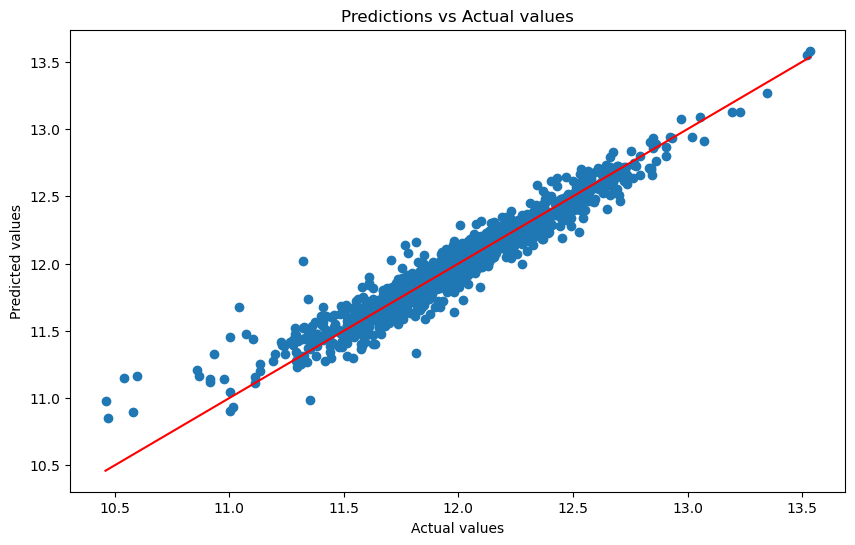

In [62]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, final_lasso.predict(X_train_df))
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predictions vs Actual values')
plt.show()

Nous constatons que les valeurs  pr√©dites disposant d'un prix de vente minime ont √©t√© sur√©valul√©s. Cela est d√ª au fait que notre dataset dispose peu de donn√©es sur les maisons en dessous de la moyenne au niveau du prix de vente. 

### Analyse de la s√©lection de la meilleure valeur d'alpha
 - La meilleure valeur d'alpha est s√©lectionn√©e en utilisant les scores de validation crois√©e.
 - Cela garantit que nous choisissons une valeur d'alpha qui optimise la performance du mod√®le sur des donn√©es de validation, et non uniquement sur les donn√©es d'entra√Ænement.
 - En affichant la meilleure valeur d'alpha, nous pouvons l'utiliser pour entra√Æner notre mod√®le final de r√©gression Lasso, assurant ainsi la meilleure performance possible.

### XGradient Boosting
Pour optimiser les hyperparam√®tres du mod√®le ExtremmeGradientBoosting, nous avons utilis√© Optuna avec la fonction RMSLE (Root Mean Squared Log Error) comme m√©trique d'√©valuation (qui est particuli√®rement appropri√©e pour des valeurs cibles avec une large gamme ou des valeurs extr√™mes). Les donn√©es pr√©trait√©es sont pr√©par√©es pour Optuna, et une fonction d'objectif sp√©cifie les hyperparam√®tres √† optimiser. 

In [63]:
import optuna
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
import xgboost as xgb

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

X_preprocessed = X_train_df
y = y_train

def objective_xgb(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': 1e-2,  # Utiliser la valeur ajust√©e d'alpha
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'early_stopping_rounds': 50  #√©viter le warning
    }

    model = xgb.XGBRegressor(**xgb_params, random_state=42, objective='reg:squarederror')
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmsle_scores = []
    
    for train_index, valid_index in kf.split(X_preprocessed):
        X_train, X_valid = X_preprocessed.iloc[train_index], X_preprocessed.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        model.fit(X_train, np.log1p(y_train), eval_set=[(X_valid, np.log1p(y_valid))], verbose=False)
        preds = model.predict(X_valid)
        score = rmsle(np.log1p(y_valid), preds)
        rmsle_scores.append(score)
    
    return np.mean(rmsle_scores)

sampler = optuna.samplers.TPESampler()
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=200)  

print("Best hyperparameters for XGB =", study_xgb.best_trial.params)

final_model_xgb = xgb.XGBRegressor(**study_xgb.best_trial.params, random_state=42, objective='reg:squarederror')
final_model_xgb.fit(X_train_df, y_train, eval_set=[(X_train_df, np.log1p(y_train))], verbose=False)

[I 2024-06-18 22:14:19,636] A new study created in memory with name: no-name-3a041e4a-8b2f-4f67-a35d-9317042838a6
[I 2024-06-18 22:14:45,426] Trial 0 finished with value: 0.002733715605589303 and parameters: {'n_estimators': 1751, 'max_depth': 8, 'learning_rate': 0.014556429820682278, 'subsample': 0.8547881494957734, 'colsample_bytree': 0.968874318867242, 'min_child_weight': 10, 'reg_lambda': 2.1134778554798635e-08, 'gamma': 2.1864104930099238e-08}. Best is trial 0 with value: 0.002733715605589303.
[I 2024-06-18 22:14:48,097] Trial 1 finished with value: 0.008205167979236982 and parameters: {'n_estimators': 1831, 'max_depth': 16, 'learning_rate': 0.15132623200943388, 'subsample': 0.8694918405216159, 'colsample_bytree': 0.3305242049726893, 'min_child_weight': 4, 'reg_lambda': 0.00015848335306225487, 'gamma': 0.4129655200536892}. Best is trial 0 with value: 0.002733715605589303.
[I 2024-06-18 22:14:58,362] Trial 2 finished with value: 0.0025974843242431425 and parameters: {'n_estimators'

KeyboardInterrupt: 

Pour √©valuer la performance du mod√®le XGBoost sur des donn√©es non vues, nous avons utilis√© le mod√®le final entra√Æn√© pour pr√©dire les valeurs cibles des donn√©es de test. Les pr√©dictions sur les donn√©es d'entra√Ænement ont √©galement √©t√© effectu√©es pour analyser la performance du mod√®le sur cet ensemble. Les pr√©dictions et les valeurs r√©elles, transform√©es avec `log1p` pour la normalisation, ont √©t√© ramen√©es √† leur √©chelle normale avec `expm1` pour une interpr√©tation dans leur unit√© originale, tout comme les prix de vente.

In [25]:
# Pr√©dictions sur les donn√©es de test pour XGBoost
y_test_pred_xgb = final_model_xgb.predict(X_test_df)

# Pr√©dictions sur les donn√©es de formation pour XGBoost
y_train_pred_xgb = final_model_xgb.predict(X_train_df)

# Revenir √† l'√©chelle normale
y_test_pred_xgb = np.expm1(y_test_pred_xgb)
y_train_pred_xgb = np.expm1(y_train_pred_xgb)
y_train_true = np.expm1(y_train)

### Analyse des pr√©dictions

 - Les pr√©dictions sur les donn√©es de test (`y_test_pred_xgb`) sont cruciales pour √©valuer la capacit√© du mod√®le √† g√©n√©raliser sur des donn√©es non vues. Cela nous a donn√© une indication de la performance du mod√®le en situation r√©elle, o√π les donn√©es de test repr√©sentaient de nouveaux exemples que le mod√®le n'avait jamais rencontr√©s pendant l'entra√Ænement (une bonne performance sur cet ensemble sugg√®re que le mod√®le n'a pas surappris les donn√©es d'entra√Ænement et peut faire des pr√©dictions pr√©cises sur des donn√©es nouvelles).

 - Les pr√©dictions sur les donn√©es d'entrainement (`y_train_pred_xgb`) permettent de v√©rifier l'ajustement du mod√®le sur les donn√©es d'entra√Ænement. Une analyse de ces pr√©dictions peut r√©v√©ler si le mod√®le a bien captur√© les relations pr√©sentes dans les donn√©es d'entra√Ænement. Cependant, une trop bonne performance sur les donn√©es d'entra√Ænement compar√©e aux donn√©es de test peut indiquer un surapprentissage (overfitting), o√π le mod√®le est trop ajust√© aux particularit√©s des donn√©es d'entra√Ænement et ne g√©n√©ralise pas bien.

 - Le retour √† l'√©chelle normale (`expm1`) des pr√©dictions et des valeurs r√©elles nous a permis d'interpr√©ter les r√©sultats en termes de prix de vente r√©els. Initialement, les valeurs cibles ont √©t√© transform√©es avec `log1p` (pour normaliser les donn√©es et g√©rer les valeurs extr√™mes ou les distributions skew√©es). En utilisant `expm1`, nous avons converti ces valeurs transform√©es de retour √† leur √©chelle d'origine, ce qui nous a facilit√© l'interpr√©tation des r√©sultats dans un contexte pratique, par exemple en termes de prix de vente (√©tape essentielle pour pr√©senter les pr√©dictions de mani√®re compr√©hensible aux parties prenantes non techniques).

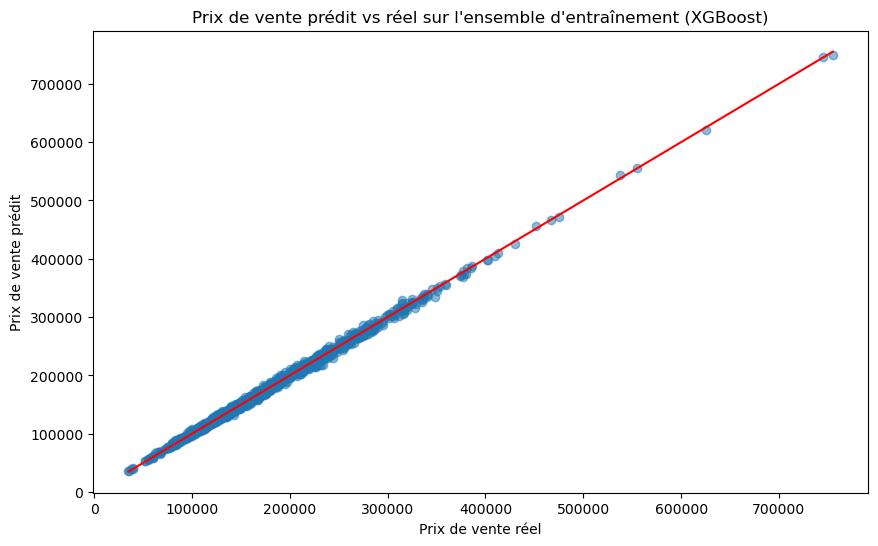

In [50]:
# Tracer les pr√©dictions vs valeurs r√©elles pour l'ensemble de test
# Cette visualisation permet de comparer les pr√©dictions du mod√®le avec les valeurs r√©elles.
# Un bon mod√®le aura ses pr√©dictions proches de la ligne rouge (y = x), ce qui signifie que les pr√©dictions sont similaires aux valeurs r√©elles.
# Tracer les pr√©dictions vs valeurs r√©elles pour l'ensemble d'entra√Ænement
# Tracer les pr√©dictions vs valeurs r√©elles pour l'ensemble d'entra√Ænement
# Charger les valeurs r√©elles de l'ensemble de test

plt.figure(figsize=(10, 6))
plt.scatter(y_train_true, y_train_pred_xgb, alpha=0.5)
plt.plot([min(y_train_true), max(y_train_true)], [min(y_train_true), max(y_train_true)], color='red')
plt.xlabel("Prix de vente r√©el")
plt.ylabel("Prix de vente pr√©dit")
plt.title("Prix de vente pr√©dit vs r√©el sur l'ensemble d'entra√Ænement (XGBoost)")
plt.show()


### Analyse du graphique pr√©dictions vs valeurs r√©elles :


L'objectif de ce graphique est de d√©montrer la performance de notre mod√®le ind√©pendamment de la soumission sur kaggle. 
 - Le graphique montre la relation entre les valeurs r√©elles et les pr√©dictions faites par le mod√®le XGBoost.
 - Les points de donn√©es repr√©sentent les paires (valeur r√©elle, pr√©diction).
 - La ligne rouge (y = x) repr√©sente les points o√π les pr√©dictions sont exactement √©gales aux valeurs r√©elles.
 - Un bon ajustement est indiqu√© par les points proches de cette ligne rouge, ce qui sugg√®re que les pr√©dictions sont pr√©cises.
 - Les √©carts significatifs par rapport √† la ligne rouge peuvent indiquer des erreurs de pr√©diction ou des zones o√π le mod√®le pourrait √™tre am√©lior√©.
 - La proximit√© des points √† la ligne rouge dans ce graphique indique que le mod√®le XGBoost est bien calibr√© et a une bonne capacit√© pr√©dictive.
 - La l√©g√®re dispersion des points autour de la ligne rouge est normale et indique des erreurs de pr√©diction relativement faibles et uniform√©ment r√©parties.
 - Les valeurs extr√™mes sont √©galement bien pr√©dites, montrant que le mod√®le g√©n√©ralise bien sur l'ensemble des donn√©es, y compris les valeurs extr√™mes.
 - En conclusion, le mod√®le XGBoost d√©montre une haute pr√©cision et un faible biais dans les pr√©dictions, confirmant son efficacit√© pour pr√©dire les prix de vente dans ce contexte.

### ADABOOST

In [53]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
def objective_adaboost(trial):
    ab_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'estimator__max_depth': trial.suggest_int('estimator__max_depth', 1, 10)
    }

    estimator = DecisionTreeRegressor(max_depth=ab_params.pop('estimator__max_depth'))
    model = AdaBoostRegressor(estimator=estimator, **ab_params, random_state=42)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmsle_scores = []
    
    for train_index, valid_index in kf.split(X_preprocessed):
        X_train_fold, X_valid_fold = X_preprocessed.iloc[train_index], X_preprocessed.iloc[valid_index]
        y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]
        
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_valid_fold)
        score = rmsle(y_valid_fold, preds)
        rmsle_scores.append(score)
    
    return np.mean(rmsle_scores)

# Utiliser Optuna pour l'optimisation bay√©sienne
sampler = optuna.samplers.TPESampler()
study_ab = optuna.create_study(direction='minimize', sampler=sampler)
study_ab.optimize(objective_adaboost, n_trials=50)

# Afficher les meilleurs hyperparam√®tres trouv√©s par Optuna
print("Best hyperparameters for AdaBoost =", study_ab.best_trial.params)

# Entra√Æner le mod√®le final avec les meilleurs hyperparam√®tres pour AdaBoost
best_params = study_ab.best_trial.params
estimator = DecisionTreeRegressor(max_depth=best_params.pop('estimator__max_depth'))
final_model_ab = AdaBoostRegressor(estimator=estimator, **best_params, random_state=42)
final_model_ab.fit(X_preprocessed, y)  # Utiliser toutes les donn√©es d'entra√Ænement

# √âvaluation finale du mod√®le AdaBoost
kf = KFold(n_splits=5, shuffle=True, random_state=42)
final_rmsle_scores_ab = []

for train_index, valid_index in kf.split(X_preprocessed):
    X_train_fold, X_valid_fold = X_preprocessed.iloc[train_index], X_preprocessed.iloc[valid_index]
    y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]
    
    final_model_ab.fit(X_train_fold, y_train_fold)
    

[I 2024-06-09 16:55:41,465] A new study created in memory with name: no-name-4e37ae98-0148-4587-99f1-1021e7e79c4e
[I 2024-06-09 16:56:54,874] Trial 0 finished with value: 0.01201811594144855 and parameters: {'n_estimators': 646, 'learning_rate': 0.0266300771744241, 'estimator__max_depth': 4}. Best is trial 0 with value: 0.01201811594144855.
[I 2024-06-09 16:58:24,446] Trial 1 finished with value: 0.011674010989456557 and parameters: {'n_estimators': 951, 'learning_rate': 0.08656110655917369, 'estimator__max_depth': 4}. Best is trial 1 with value: 0.011674010989456557.
[I 2024-06-09 16:58:49,773] Trial 2 finished with value: 0.018883881789658035 and parameters: {'n_estimators': 593, 'learning_rate': 0.02028706426910223, 'estimator__max_depth': 1}. Best is trial 1 with value: 0.011674010989456557.
[I 2024-06-09 17:00:13,346] Trial 3 finished with value: 0.010854071986017823 and parameters: {'n_estimators': 318, 'learning_rate': 0.6231892404652669, 'estimator__max_depth': 10}. Best is tri

Best hyperparameters for AdaBoost = {'n_estimators': 480, 'learning_rate': 0.9665351113909071, 'estimator__max_depth': 7}


In [54]:
preds = final_model_ab.predict(X_valid_fold)
score = rmsle(y_valid_fold, preds)
final_rmsle_scores_ab.append(score)

print(f"Final RMSLE scores (AdaBoost): {final_rmsle_scores_ab}")
print(f"Mean Final RMSLE (AdaBoost): {np.mean(final_rmsle_scores_ab)}")

# Pr√©dictions sur les donn√©es de test pour AdaBoost
y_test_pred_ab = final_model_ab.predict(X_test_df)
y_test_pred_ab = np.expm1(y_test_pred_ab)

Final RMSLE scores (AdaBoost): [0.009197156144999552]
Mean Final RMSLE (AdaBoost): 0.009197156144999552


### Analyse du graphique Pr√©dictions vs Valeurs R√©elles :


In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_train_exp, ab_train_predictions, alpha=0.5)
plt.plot([min(y_train_exp), max(y_train_exp)], [min(y_train_exp), max(y_train_exp)], color='red')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('AdaBoost Regression: Predicted vs Actual SalePrice')
plt.show()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Conversion des logarithmes en valeurs r√©elles pour la comparaison
y_valid_real = np.expm1(y_valid_fold)
preds_real = np.expm1(preds)

# Cr√©ation d'un DataFrame pour les valeurs r√©elles et pr√©dites
comparison_df = pd.DataFrame({
    'Real': y_valid_real,
    'Predicted': preds_real
})

# Affichage des premi√®res lignes pour v√©rifier
print(comparison_df.head())

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.scatter(y_valid_real, preds_real, alpha=0.3)
plt.plot([y_valid_real.min(), y_valid_real.max()], [y_valid_real.min(), y_valid_real.max()], 'k--', lw=2)
plt.xlabel('Valeurs R√©elles')
plt.ylabel('Valeurs Pr√©dites')
plt.title('Comparaison des valeurs r√©elles et pr√©dites')
plt.show()

NameError: name 'y_valid_fold' is not defined

In [55]:
# Pr√©parer les fichiers de soumission
submission_xgb = pd.DataFrame({
    'Id': test_data.index,
    'SalePrice': y_test_pred_xgb
})
submission_lasso = pd.DataFrame({
    'Id': test_data.index,
    'SalePrice': lasso_predictions
})

submission_ab = pd.DataFrame({
    'Id': test_data.index,
    'SalePrice': y_test_pred_ab
})

# Sauvegarder les fichiers de soumission
submission_xgb.to_csv('submission_xgb.csv', index=False)
submission_lasso.to_csv('lasso_submission.csv', index=False)
submission_ab.to_csv('submission_AB.csv', index=False)

print("Les fichiers de soumission sont pr√™ts : 'submission_xgb.csv' , 'submission_AB.csv' et 'lasso_submission.csv'")


Les fichiers de soumission sont pr√™ts : 'submission_xgb.csv' , 'submission_AB.csv' et 'lasso_submission.csv'


# Utilisation de MLFlow pour les √©valuations
Chaque mod√®le est sauvegard√© dans MLFlow afin de conserver une trace et en vue d'un futur d√©ploiement.

In [29]:
# pip install mlflow
# pip install setuptools

Apr√®s avoir install√© mlflow, nous avons d'abord d√ª d√©marrer un serveur de suivi local. La commande suivante a √©t√© utilis√©e dans le terminal :
- **mlflow server --host 127.0.0.1 --port 8080**

### Configuration de l'URI de suivi MLflow
MLflow a √©t√© configur√© pour suivre les exp√©riences de machine learning et g√©rer les mod√®les. L'URI de suivi est lui d√©fini pour indiquer o√π les informations de suivi seront stock√©es. √Ä ce moment, le nom de l'exp√©rience est √©galement d√©fini pour organiser les diff√©rentes ex√©cutions.

In [57]:
import mlflow
import warnings
from mlflow.models import infer_signature
warnings.filterwarnings('ignore', module='mlflow')

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("House Prices Prediction")

c:\Users\blerdon\anaconda3\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\blerdon\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'xgboost_regressor_model' already exists. Creat

Le mod√®le XGBoost a √©t√© enregistr√© avec MLflow.


c:\Users\blerdon\anaconda3\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'lasso_regressor_model'.
2024/06/09 18:47:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lasso_regressor_model, version 1
Created ve

Le mod√®le Lasso a √©t√© enregistr√© avec MLflow.


c:\Users\blerdon\anaconda3\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'adaboost_regressor_model' already exists. Creating a new version of this model...
2024/06/09 18:50:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name

Le mod√®le AdaBoost a √©t√© enregistr√© avec MLflow.


Created version '2' of model 'adaboost_regressor_model'.


In [ ]:
# Entra√Æner et enregistrer le mod√®le XGBoost avec MLflow
with mlflow.start_run(run_name="XGBoost Model"):
    best_params_xgb = study_xgb.best_trial.params
    final_model_xgb = xgb.XGBRegressor(**best_params_xgb, random_state=42, objective='reg:squarederror')
    
    model_pipeline_xgb = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', final_model_xgb)
    ])
    
    # Entra√Æner le pipeline avec les donn√©es d'entra√Ænement
    model_pipeline_xgb.fit(X_train, y_train)
    
    # Enregistrer les hyperparam√®tres utilis√©s
    mlflow.log_params(best_params_xgb)

    # Calculer et enregistrer la m√©trique de perte (RMSLE)
    mean_rmsle_xgb = np.mean([rmsle_score for rmsle_score in study_xgb.trials_dataframe()['value']])
    mlflow.log_metric("mean_rmsle", mean_rmsle_xgb)

    # D√©finir un tag pour d√©crire l'ex√©cution
    mlflow.set_tag("Training Info", "XGBoost Regressor")

    # Inf√©rer la signature du mod√®le (entr√©e et sortie)
    signature_xgb = infer_signature(X_train, model_pipeline_xgb.predict(X_train))

    # Enregistrer le mod√®le avec MLflow
    model_info_xgb = mlflow.sklearn.log_model(
        sk_model=model_pipeline_xgb,
        signature=signature_xgb,
        input_example=X_train.head(),
        registered_model_name="xgboost_regressor_model",
        artifact_path="xgboost_regressor_model"
    )

print("Le mod√®le XGBoost a √©t√© enregistr√© avec MLflow.")


# Entra√Æner et enregistrer le mod√®le Lasso avec MLflow
with mlflow.start_run(run_name="Lasso Model"):
    lasso_params = {'alpha': best_alpha}  # Remplacer 'best_alpha' par la meilleure valeur alpha trouv√©e
    final_model_lasso = Lasso(alpha=lasso_params['alpha'], max_iter=20000)
    
    model_pipeline_lasso = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', final_model_lasso)
    ])
    
    # Entra√Æner le pipeline avec les donn√©es d'entra√Ænement
    model_pipeline_lasso.fit(X_train, y_train)
    
    # Enregistrer les hyperparam√®tres utilis√©s
    mlflow.log_params(lasso_params)

    # D√©finir un tag pour d√©crire l'ex√©cution
    mlflow.set_tag("Training Info", "Lasso Regressor")

    # Inf√©rer la signature du mod√®le (entr√©e et sortie)
    signature_lasso = infer_signature(X_train, model_pipeline_lasso.predict(X_train))

    # Enregistrer le mod√®le avec MLflow
    model_info_lasso = mlflow.sklearn.log_model(
        sk_model=model_pipeline_lasso,
        signature=signature_lasso,
        input_example=X_train.head(),
        registered_model_name="lasso_regressor_model",
        artifact_path="lasso_regressor_model"
    )

print("Le mod√®le Lasso a √©t√© enregistr√© avec MLflow.")


# Entra√Æner et enregistrer le mod√®le AdaBoost avec MLflow
with mlflow.start_run(run_name="AdaBoost Model"):
    adaboost_params = {'n_estimators': 100, 'random_state': 42}  # Sp√©cifiez les hyperparam√®tres d'AdaBoost
    final_model_adaboost = AdaBoostRegressor(**adaboost_params)
    
    model_pipeline_adaboost = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', final_model_adaboost)
    ])
    
    # Entra√Æner le pipeline avec les donn√©es d'entra√Ænement
    model_pipeline_adaboost.fit(X_train, y_train)
    
    # Enregistrer les hyperparam√®tres utilis√©s
    mlflow.log_params(adaboost_params)

    # D√©finir un tag pour d√©crire l'ex√©cution
    mlflow.set_tag("Training Info", "AdaBoost Regressor")

    # Inf√©rer la signature du mod√®le (entr√©e et sortie)
    signature_adaboost = infer_signature(X_train, model_pipeline_adaboost.predict(X_train))

    # Enregistrer le mod√®le avec MLflow
    model_info_adaboost = mlflow.sklearn.log_model(
        sk_model=model_pipeline_adaboost,
        signature=signature_adaboost,
        input_example=X_train.head(),
        registered_model_name="adaboost_regressor_model",
        artifact_path="adaboost_regressor_model"
    )

print("Le mod√®le AdaBoost a √©t√© enregistr√© avec MLflow.")


### √âthique de l'IA dans la pr√©diction des prix des maisons

L'utilisation de l'intelligence artificielle pour pr√©dire les prix des maisons pr√©sente plusieurs implications √©thiques qu'il est crucial de consid√©rer. Bien que cette technologie puisse offrir des avantages significatifs, elle peut aussi entra√Æner des risques et des in√©galit√©s si elle n'est pas d√©ploy√©e de mani√®re responsable.

#### B√©n√©fices de l'IA dans la pr√©diction des prix des maisons

L'IA peut potentiellement b√©n√©ficier √† un large √©ventail de parties prenantes :
- **Acheteurs de maisons** : peuvent obtenir des estimations pr√©cises des prix, facilitant la prise de d√©cision.
- **Vendeurs de maisons** : peuvent ajuster leurs attentes de prix en fonction des analyses pr√©dictives, augmentant les chances de vente rapide.
- **Agents immobiliers** : peuvent utiliser les pr√©dictions pour conseiller leurs clients de mani√®re plus inform√©e.
- **Institutions financi√®res** : peuvent √©valuer plus pr√©cis√©ment les risques li√©s aux pr√™ts hypoth√©caires.

#### Cr√©ation d'in√©galit√©s

Cependant, il existe des risques que l'IA puisse exacerber certaines in√©galit√©s :
- **Biais des donn√©es** : Si les donn√©es utilis√©es pour entra√Æner le mod√®le contiennent des biais historiques, l'IA peut perp√©tuer et m√™me amplifier ces biais. Par exemple, certaines r√©gions pourraient √™tre sous-√©valu√©es syst√©matiquement.
- **Acc√®s √† la technologie** : Tous les acheteurs et vendeurs n'ont pas un acc√®s √©gal √† cette technologie. Ceux qui peuvent se permettre les outils bas√©s sur l'IA pourraient avoir un avantage injuste.
- **Transparence et explicabilit√©** : Les d√©cisions prises par des mod√®les d'IA peuvent √™tre opaques. Les parties prenantes doivent comprendre comment et pourquoi un prix a √©t√© pr√©dit, ce qui est crucial pour la confiance dans le syst√®me.

#### √âvaluation des risques

Pour g√©rer ces implications √©thiques, il est utile de cat√©goriser les risques selon leur gravit√©.

**Exemple de risque inacceptable :**
- **Discrimination syst√©matique** : Le mod√®le pr√©dit syst√©matiquement des prix inf√©rieurs pour des quartiers historiquement marginalis√©s.

**Risque √©lev√© :**
- **Biais des mod√®les** : Le mod√®le pourrait apprendre des biais pr√©sents dans les donn√©es historiques, menant √† des pr√©dictions injustes pour certaines r√©gions ou groupes d√©mographiques.
- **Violation de la vie priv√©e** : Utilisation de donn√©es personnelles sans consentement appropri√© pourrait conduire √† des probl√®mes de confidentialit√©.

**Risque limit√© :**
- **Acc√®s in√©gal aux outils d'IA** : Certaines parties de la population peuvent ne pas avoir acc√®s aux pr√©dictions de prix bas√©es sur l'IA, cr√©ant une disparit√© d'information.
- **D√©pendance excessive** : Confiance excessive dans les pr√©dictions de l'IA sans v√©rification humaine peut conduire √† des d√©cisions de march√© suboptimales.

**Risque minimal :**
- **Erreurs de pr√©diction** : Comme tout mod√®le pr√©dictif, des erreurs peuvent survenir, mais avec une bonne gestion et validation continue, ces erreurs peuvent √™tre minimis√©es et corrig√©es.
- **Impact sur les professionnels** : Les agents immobiliers et autres professionnels pourraient initialement percevoir l'IA comme une menace, mais elle peut aussi √™tre vue comme un outil compl√©mentaire qui am√©liore leurs services.

# Conclusion

Notre projet de pr√©diction des prix des maisons a d√©montr√© l'efficacit√© des mod√®les de Machine Learning pour fournir des estimations pr√©cises, qui aide les vendeurs √† fixer des prix comp√©titifs. En int√©grant ces mod√®les dans une plateforme en ligne, nous avons offert une solution pratique et accessible qui peut transformer la mani√®re dont les propri√©t√©s seront vendues, en acc√©l√©rant ainsi les transactions et en optimisant les revenus des vendeurs.

Nous recommandons de continuer √† affiner les mod√®les avec de nouvelles donn√©es ainsi que d'effectuer des analyses r√©guli√®res dans l'objectif de garantir la pr√©cision et l'√©quit√© des pr√©dictions !
